In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from data_loader import load_images_and_labels

In [2]:
# list tf devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Preprocessing and Feature Engineering Data

In [3]:
train_directory = "caltech-101/101_ObjectCategories"
test_directory = "caltech-101/test"
img_height = 224
img_width = 224

# exclude_classes = {"airplanes", "Motorbikes", "Faces", "Faces_easy", "watch", "Leopards"}
exclude_classes = set()
classes = [class_name for class_name in os.listdir(train_directory) if class_name not in exclude_classes]
classes

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'Faces',
 'Faces_easy',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'Leopards',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'Motorbikes',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

In [4]:
# if test directory does not exist, create it
if not os.path.exists(test_directory):
    print("Creating test directory")
    os.makedirs(test_directory)
    
    for class_name in classes:
        train_class_dir = os.path.join(train_directory, class_name)
        test_class_dir = os.path.join(test_directory, class_name)
        
        os.makedirs(test_class_dir)
        
        image_file_names = os.listdir(train_class_dir) # list of all images in the class
        test_images = image_file_names[:len(image_file_names) // 5] # 20% of the images
        
        for img in test_images:
            os.rename(os.path.join(train_class_dir, img), os.path.join(test_class_dir, img)) # move the image to the test directory
else:
    print("Test directory already exists")

Test directory already exists


### Data Augmentation

As seen in [exploratory_data_analysis.ipynb](exploratory_data_analysis.ipynb), each class has a different number of images. This will cause bias in our model towards certain classes. We need to fix this by generating more images for the classes that are under represented.

In [10]:
batch_size = 32

def preprocess_image(dataset):
    return (
        dataset.map(lambda x, y: (x / 255.0, y))
        .cache()
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    )

train = preprocess_image(
    tf.keras.utils.image_dataset_from_directory(
        train_directory,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,

        color_mode="rgb",
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset="training",
    )
)

val = preprocess_image(
    tf.keras.utils.image_dataset_from_directory(
        train_directory,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,

        color_mode="rgb",
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset="validation",
    )
)

test = preprocess_image(
    tf.keras.utils.image_dataset_from_directory(
        test_directory,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,

        color_mode="rgb",
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
    )
)

Found 6982 files belonging to 101 classes.
Using 5586 files for training.
Found 6982 files belonging to 101 classes.
Using 1396 files for validation.
Found 1695 files belonging to 101 classes.


# CNN Model

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 512)               2

In [7]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="high_res_shit.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train,
    epochs=100,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_learning_rate_callback],
    validation_data=val
)

Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 31.4750 - accuracy: 0.1380
Epoch 1: val_accuracy improved from -inf to 0.17908, saving model to high_res_shit.h5
175/175 [==============================] - 154s 797ms/step - loss: 31.4750 - accuracy: 0.1380 - val_loss: 4.4263 - val_accuracy: 0.1791 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 4.0518 - accuracy: 0.2005
Epoch 2: val_accuracy improved from 0.17908 to 0.20344, saving model to high_res_shit.h5
175/175 [==============================] - 119s 683ms/step - loss: 4.0518 - accuracy: 0.2005 - val_loss: 4.0135 - val_accuracy: 0.2034 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - ETA: 0s - loss: 3.8589 - accuracy: 0.2204
Epoch 3: val_accuracy improved from 0.20344 to 0.23138, saving model to high_res_shit.h5
175/175 [==============================] - 66s 338ms/step - loss: 3.8589 - accuracy: 0.2204 - val_loss: 3.8057 - val_accuracy: 0.2314 - lr: 0.0010


In [8]:
test_loss, test_acc = model.evaluate(test)
print("Test accuracy:", test_acc)

53/53 [==============================] - 4s 65ms/step - loss: 3.4325 - accuracy: 0.4313
Test accuracy: 0.4312684237957001


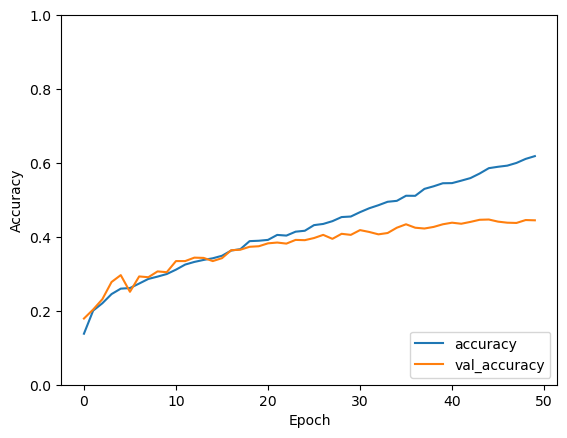

In [9]:
# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Use transfer learning to improve results and stop overfitting

In [16]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet"
)

base_model.trainable = False

model = tf.keras.models.Sequential(
    [
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

learning_rate = 0.001 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

In [17]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="resnet_high_res.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)


history = model.fit(
    train, epochs=100, batch_size=batch_size, validation_data=val, callbacks=[checkpoint_callback, early_stopping_callback, reduce_learning_rate_callback]
)

Epoch 1/100


 88/175 [==============>...............] - ETA: 3:14 - loss: 4.3128 - accuracy: 0.1254

KeyboardInterrupt: 

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 42ms/step - loss: 1.6861 - accuracy: 0.5600
Test accuracy: 0.5600329041481018


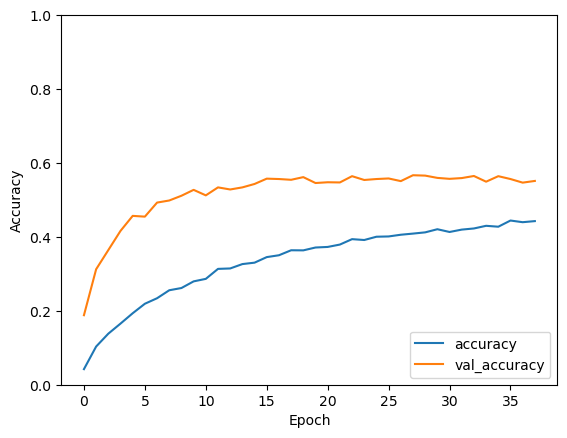

In [27]:
# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 

As we can see above, using the pretrained model has helped stop the overfitting, but our evaluation accuracy is plateauing at around 55%. Let's fix that by adjusting the layers.

In [28]:
base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

# unfreeze the last layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

batch_size = 32

learning_rate = 0.001 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_transfer_learning_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
243/244 [============================>.] - ETA: 0s - loss: 5.0485 - accuracy: 0.0869
Epoch 1: val_accuracy improved from -inf to 0.26670, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 17s 63ms/step - loss: 5.0481 - accuracy: 0.0869 - val_loss: 3.5296 - val_accuracy: 0.2667
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 3.3034 - accuracy: 0.2801
Epoch 2: val_accuracy improved from 0.26670 to 0.41470, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 12s 51ms/step - loss: 3.3027 - accuracy: 0.2804 - val_loss: 2.7285 - val_accuracy: 0.4147
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 2.7721 - accuracy: 0.3875
Epoch 3: val_accuracy improved from 0.41470 to 0.50925, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 13s 51ms/step - loss: 2.7728 - accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 34ms/step - loss: 1.4099 - accuracy: 0.7064
Test accuracy: 0.7064144611358643


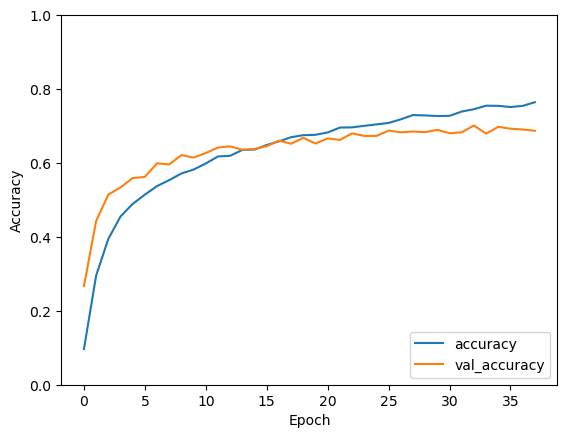

In [ ]:
# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 

# Accuracy is higher, but still not fully reliable. Choosing a pretrained model with more layers should give better results.

In [ ]:
# use inceptionv3
base_model = tf.keras.applications.InceptionV3(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

# unfreeze the last layers of the base model
for layer in base_model.layers[-40:]:
    layer.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

batch_size = 32

learning_rate = 0.0005 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_377 (Conv2D)            (None, 63, 63, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_377 (Batch  (None, 63, 63, 32)  96          ['conv2d_377[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="InceptionV3.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 35ms/step - loss: 2.8869 - accuracy: 0.5909
Test accuracy: 0.5908716917037964


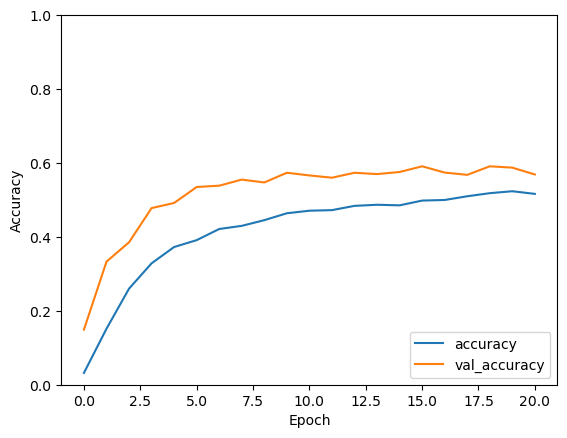

In [ ]:
# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 